In [10]:
# All libraries & Data points
import jetset
print('tested on jetset',jetset.__version__)
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from jetset.data_loader import Data
from jetset.data_loader import ObsData
from jetset.plot_sedfit import PlotSED
from jetset.jet_model import Jet
from jetset.minimizer import fit_SED,ModelMinimizer
from jetset.model_manager import  FitModel
from jetset.sed_shaper import  SEDShape
from jetset.obs_constrain import ObsConstrain
from jetset.minimizer import fit_SED
from jetset.template_2Dmodel import EBLAbsorptionTemplate
from jetset.mcmc import McmcSampler
sed_data=ObsData.load('J163547_data.pkl')
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'figure.dpi' : 100})
plt.rcParams["savefig.bbox"] = 'tight'

L_Disk5=9.856093E+045
L_Disk8=1.407945E+046
L_Disk1=1.990955E+046
L_Disk15=3.372705E+046
L_Disk2=4.223855E+046
L_Disk3=5.775215E+046

L_Disk=np.array([L_Disk5,L_Disk8,L_Disk1,L_Disk15,L_Disk2,L_Disk3])
P_j=np.array([3.402446e+46,3.786684e+46,3.209580e+46,3.675279e+46,4.097556e+46,5.187664e+46])
P_rad = np.array([9.525887e+44,8.082170e+44,5.976000e+44,5.076367e+44,4.902777e+44,5.244207e+44])
P_B=np.array([3.738258e+43,3.605148e+43,1.339113e+43,3.678683e+42,3.481325e+42,8.633887e+42])
P_e=np.array([7.370941e+45,7.846307e+45,7.708881e+45,9.491933e+45,1.060285e+46,1.189135e+46])
P_p=np.array([2.566355e+46,2.917627e+46,2.377593e+46,2.674954e+46,2.987894e+46,3.945223e+46])
P_kin=np.array([3.303449e+46,3.702257e+46,3.148481e+46,3.624148e+46,4.048180e+46,5.134358e+46])

tested on jetset 1.2.2


In [8]:
jet = FitModel.load_model("fit_model_3_3.pkl")
jet.jet_leptonic.energetic_report()

==> par R_DT is now depending on ['L_Disk'] according to expr:R_DT =
2E19*(L_Disk/1E46)**0.5
==> par R_BLR_in is now depending on ['L_Disk'] according to expr:R_BLR_in =
3E17*(L_Disk/1E46)**0.5
==> par R_BLR_out is now depending on ['R_BLR_in'] according to expr:R_BLR_out =
R_BLR_in*1.1
==> par R is now depending on ['R_H', 'theta_open'] according to expr:R =
np.tan((theta_open*np.pi/180))*R_H


name,type,units,val
BulkLorentzFactor,jet-bulk-factor,,1.520138e+01
U_e,Energy dens. blob rest. frame,erg / cm3,2.732446e-02
U_p_cold,Energy dens. blob rest. frame,erg / cm3,9.065504e-02
U_B,Energy dens. blob rest. frame,erg / cm3,1.983932e-05
U_Synch,Energy dens. blob rest. frame,erg / cm3,8.196238e-05
U_Synch_DRF,Energy dens. disk rest. frame,erg / cm3,9.845189e+00
U_Disk,Energy dens. blob rest. frame,erg / cm3,5.112305e-06
U_BLR,Energy dens. blob rest. frame,erg / cm3,1.689911e-04
U_DT,Energy dens. blob rest. frame,erg / cm3,8.301861e-04
U_CMB,Energy dens. blob rest. frame,erg / cm3,0.000000e+00


[46.29473479 46.44961569 46.60009144 46.82900835 46.926739   47.06259815]
[46.83282124 46.87928906 46.8074782  46.86632031 46.91355489 47.01600184]
38.11683583033818 0.18779956838187536 0.0605658193065828


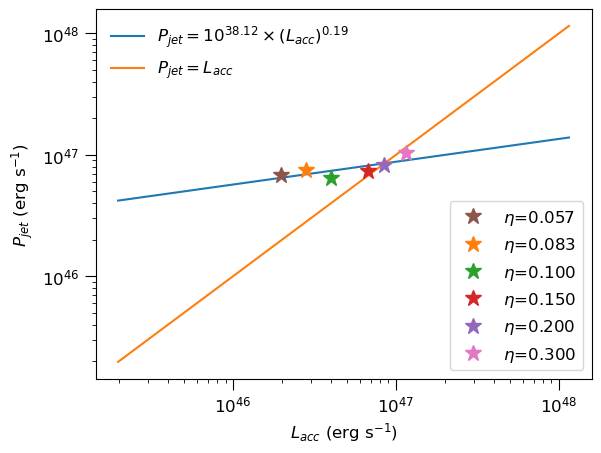

[2.79971732 2.13436611 1.86192586 1.38121949 1.19651251 1.01089951]


In [20]:
etas = np.array([0.057,0.083,0.100,0.150,0.200,0.300])
x = np.log10((2*L_Disk))
y = np.log10(P_j*2)
print(x)
print(y)
N=len(x)

def a_b_delta_values(x,y):
    by = 0
    bx = 0
    xmean = sum(x)/N
    ymean = sum(y)/N
    x2=np.zeros(N,float)

    for i in range(N):
        by += y[i]*(x[i]-xmean)
        bx += x[i]*(x[i]-xmean)
        x2[i]=x[i]**2
        
    b=by/bx
    a=ymean-xmean*b
    delta=N*sum(x2)-sum(x)**2
    return a, b, delta, x2

def fit_leastsquare(x,y):
    a, b, delta, x2 = a_b_delta_values(x,y)
    xfit = np.linspace(min(x)-1,max(x)+1,N)
    yfit = np.zeros(N,float)
    sigmaysum=0
    
    for i in range(N):
        yfit[i]=a+b*xfit[i]
    
    for i in range(N-1):
        sigmaysum+=(y[i]-a-b*x[i])**2
        
    sigmay=np.sqrt((1/(N-1))*sigmaysum)
    sigmaa=sigmay*np.sqrt(sum(x2)/delta)
    sigmab=sigmay*np.sqrt(N/delta)
    
    return np.power(10,xfit), np.power(10,yfit), np.power(10,sigmay), sigmaa, sigmab

xfit, yfit, sigmay, sigmaa, sigmab=fit_leastsquare(x,y)
a, b, delta, x2 = a_b_delta_values(x,y)
x = np.power(10,x)
y = np.power(10,y)
print(a,b,sigmab)
#plt.text(0.0,-5.5, f'a = {np.round(a,2)} $\pm$ {np.round(sigmaa,2)}')
#plt.text(0.0,-6.5, f'b = {np.round(b,2)} $\pm$ {np.round(sigmab,2)}')
#plt.text(0.0,-7.5, f'$\sigma_{"y"}$ = {np.round(sigmay,5)}')

import matplotlib.ticker as ticker

c5='#8c564b'
c8='#ff7f0e'
c1='#2ca02c'
c15='#d62728'
c2='#9467bd'
c3='#e377c2'
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots()
g1, = ax.loglog(xfit,yfit,"-")
g2, = ax.loglog(xfit,xfit,"-")
ax.plot(x[0],y[0],"*", label=r"$\eta$=0.057", color=c5, markersize=12)
ax.plot(x[1],y[1],"*", label=r"$\eta$=0.083", color=c8, markersize=12)
ax.plot(x[2],y[2],"*", label=r"$\eta$=0.100", color=c1, markersize=12)
ax.plot(x[3],y[3],"*", label=r"$\eta$=0.150", color=c15, markersize=12)
ax.plot(x[4],y[4],"*", label=r"$\eta$=0.200", color=c2, markersize=12)
ax.plot(x[5],y[5],"*", label=r"$\eta$=0.300", color=c3, markersize=12)
ax.set_ylabel(r'$P_{jet}$ (erg s$^{{-1}})$')
ax.set_xlabel(r'$L_{acc}$ (erg s$^{{-1}})$')
#ax.xaxis.set_major_locator(plt.MaxNLocator(8))
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
#ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
#ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(axis='both', which='major', labelsize=12, length=8)
ax.tick_params(axis='both', which='minor', labelsize=12, length=3)

#plt.grid(True)
leg1 = ax.legend(fontsize=12)
leg2 = ax.legend([g1,g2],[fr"$P_{{jet}}=10^{{{np.round(a,2)}}}\times(L_{{acc}})^{{{np.round(b,2)}}}$",
                           fr"$P_{{jet}}=L_{{acc}}$"],
                  fontsize=12,frameon=False)
ax.add_artist(leg1)
#plt.xlim(3e47,5e48)
#plt.ylim(3e45,5e47)
plt.savefig("pvl.png")
plt.show()
print(100*P_rad/P_j)